In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function
import os
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import json
from collections import defaultdict
import re
from random import choice
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
import json
from IPython.display import FileLink
from tqdm import tqdm
tqdm.monitor_interval = 0  
import requests

In [3]:
import gc

In [4]:
images_path = "../input/flickr-image-dataset/flickr30k_images/flickr30k_images"
captions_link = "../input/flickr-image-dataset/flickr30k_images/results.csv"

In [5]:
images_files_names = os.listdir(images_path)
csv_captions = pd.read_csv(captions_link,sep="|")
print(csv_captions.head())

       image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  


In [6]:
captions_list = []
image_captions = []
for i in tqdm(range(0,len(images_files_names))):
    if images_files_names[i] in ["flickr30k_images","results.csv"]:
            continue
    image_caption_dataframe = csv_captions.loc[csv_captions["image_name"] == images_files_names[i]]
    captions_list += [list(image_caption_dataframe[" comment"])]

100%|██████████| 31785/31785 [05:12<00:00, 101.72it/s]


In [7]:
captions_list[:2]

[[' a man wearing a red hat and blue top carries a tray on his head filled with some sort of baked goods .',
  ' A man with a large plate of food on his head walks down a street .',
  ' A man wearing a hat is balancing a tray of food on his head .',
  ' A man is balancing a plate of food on his head .',
  ' Wow , found a new way to serve food .'],
 [' A boy is doing tricks with his bike on the ramp .',
  ' A teenage boy on a bicycle does tricks .',
  ' A man on a bike jumping on a bike ramp .',
  ' A boy rides his bike on a half-pipe .',
  ' A cyclist gets airborne on a ramp .']]

In [8]:
images_files_names.remove("flickr30k_images")
images_files_names.remove("results.csv")

In [9]:
captions_list[1][1][1:]

'A teenage boy on a bicycle does tricks .'

In [10]:
for i in tqdm(range(len(captions_list))):
    captions_list[i] = [sentence for sentence in captions_list[i] if not (pd.isnull(sentence)) == True]
    for j in range(len(captions_list[i])):
        captions_list[i][j] = captions_list[i][j][1:]
        captions_list[i][j] = captions_list[i][j].replace('.', '')

100%|██████████| 31783/31783 [00:00<00:00, 123774.92it/s]


In [11]:
captions_list[1][1]

'A teenage boy on a bicycle does tricks '

In [12]:
train_captions, val_captions, train_images_files_names, val_images_files_names = train_test_split(captions_list,images_files_names,test_size=0.20, random_state=41)

In [13]:
def vizualize_random_images(train_images_files_names,train_captions,sample_size_to_display):
        sample_size_to_display = random.sample(range(0,np.array(train_images_files_names).shape[0]), sample_size_to_display)
        for i in range(0,len(sample_size_to_display)): 
            figure_size = 10
            plt.figure(figsize=(figure_size,figure_size))
            plt.subplot(1,2,1)
            plt.title("\n".join(train_captions[sample_size_to_display[i]]))
            img = cv2.imread("../input/flickr-image-dataset/flickr30k_images/flickr30k_images/"+train_images_files_names[sample_size_to_display[i]])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.show()

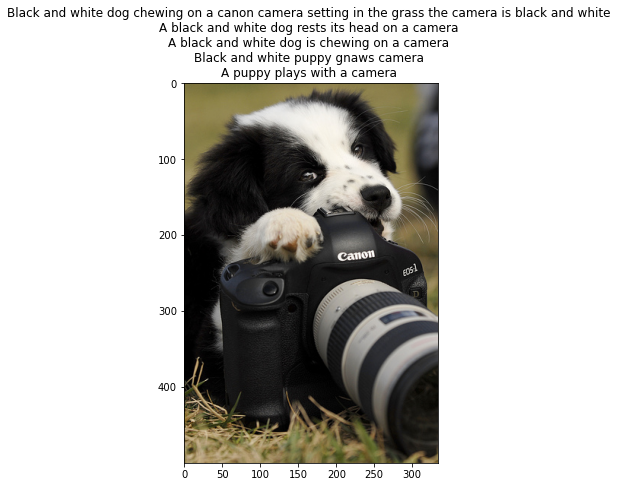

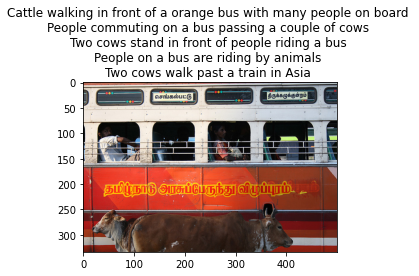

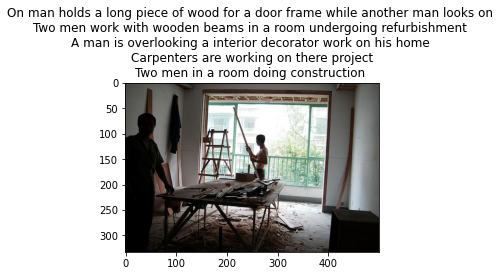

In [14]:
vizualize_random_images(train_images_files_names,train_captions,3)

In [15]:
print(len(train_captions))
print(len(val_captions))
print(len(train_images_files_names))
print(len(val_images_files_names))

25426
6357
25426
6357


In [16]:
from collections import Counter

PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

In [17]:
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    vocab = []
    for captions in train_captions:
        for caption in captions:
           caption_tokens = split_sentence(caption)
           vocab += caption_tokens
    occurences = Counter(vocab)
    vocab2 = []
    for key in occurences:
        if occurences[key] >= 5:
           vocab2 += [key]
    vocab2 = vocab2 + [PAD] + [UNK] + [START] + [END]

    return {token: index for index, token in enumerate(sorted(vocab2))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = captions.copy()
    for i in range(0,len(captions)):
      for j in range(0,len(res[i])):
        caption = split_sentence(res[i][j])
        vocab_indices = []
        for cap in caption:
            if cap in vocab.keys():
                vocab_indices = vocab_indices + [vocab[cap]]
            else:
                vocab_indices = vocab_indices + [vocab[UNK]]
                 
        vocab_indices = [vocab[START]] + vocab_indices + [vocab[END]]
        res[i][j] = vocab_indices   
    return res

In [18]:
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}

In [19]:
print(len(vocab))

6981


In [20]:
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [21]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len == None:
        columns = max(map(len, batch_captions))
    else:
        columns = min(max_len, max(map(len, batch_captions)))
    
    matrix = np.array([[ batch_captions[i][j] if j < len(batch_captions[i]) else pad_idx for j in range(0,columns)] for i in range(0,len(batch_captions))])
    return matrix

In [22]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [23]:
type(train_captions_indexed)

numpy.ndarray

In [24]:
!ls ../input/flickr-image-dataset/flickr30k_images/flickr30k_images | wc -l

31785


In [25]:
inception = InceptionV3(include_top=False)
preprocess_for_model = keras.applications.inception_v3.preprocess_input
model = keras.models.Model(inception.inputs, keras.layers.GlobalAveragePooling2D()(inception.output))
size = 299
train_img_embeds = []
for image in tqdm(train_images_files_names):
    img = tf.keras.preprocessing.image.load_img("../input/flickr-image-dataset/flickr30k_images/flickr30k_images/"+image,target_size=(size,size))
    img = img_to_array(img)   
    img = np.expand_dims(np.array(preprocess_for_model(img)),axis=0)
    train_img_embeds = train_img_embeds + [model.predict(img, verbose=0)[0]]

2023-01-28 03:35:05.681680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 03:35:05.781528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 03:35:05.782266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 03:35:05.784060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 5s 0us/step


  0%|          | 0/25426 [00:00<?, ?it/s]2023-01-28 03:35:15.878518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-28 03:35:17.944204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 25426/25426 [27:14<00:00, 15.55it/s]


In [26]:
size = 299
val_img_embeds = []
for image in tqdm(val_images_files_names):
    img = tf.keras.preprocessing.image.load_img("../input/flickr-image-dataset/flickr30k_images/flickr30k_images/"+image,target_size=(size,size))
    img = img_to_array(img)   
    img = np.expand_dims(np.array(preprocess_for_model(img)),axis=0)
    val_img_embeds = val_img_embeds + [model.predict(img, verbose=0)[0]]

val_img_embeds = np.array(val_img_embeds)

100%|██████████| 6357/6357 [06:44<00:00, 15.72it/s]


In [27]:
IMG_EMBED_SIZE = np.array(train_img_embeds).shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [28]:
tf.compat.v1.disable_eager_execution()

In [36]:
tf.compat.v1.reset_default_graph()

In [34]:
L = keras.layers
K = keras.backend

In [37]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.compat.v1.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.compat.v1.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    
    # lstm cell (from tensorflow)
    lstm = tf.compat.v1.nn.rnn_cell.LSTMCell(LSTM_UNITS)

    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
   
    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])
    
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.compat.v1.nn.dynamic_rnn(lstm, word_embeds,initial_state=tf.compat.v1.nn.rnn_cell.LSTMStateTuple(c0, h0))
    
    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    
    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))

    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])
   

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    #flat_loss_mask = tf.where(tf.equal(flat_ground_truth, tf.constant( pad_idx ) ) , tf.zeros_like(flat_ground_truth), tf.ones_like(flat_ground_truth)) 
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx) 

    

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    #loss = tf.reduce_mean(tf.where(tf.equal(flat_loss_mask, tf.constant(1)), xent, tf.zeros_like(xent)))
    loss =  tf.reduce_mean(input_tensor=tf.boolean_mask(tensor=xent, mask=flat_loss_mask))

In [38]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.compat.v1.train.Saver()

In [39]:
s = tf.compat.v1.keras.backend.get_session()
s.run(tf.compat.v1.global_variables_initializer())

2023-01-28 04:16:11.108597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 04:16:11.109510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 04:16:11.110148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 04:16:11.110980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 04:16:11.111632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [40]:
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """

    idx = np.random.randint(len(images_embeddings), size=batch_size)
    
    batch_image_embeddings = images_embeddings[idx]
     
    batch_captions = []
    for i in range(0,len(indexed_captions[idx])):
               batch_captions_matrix = random.choice(indexed_captions[idx][i])
               batch_captions += [batch_captions_matrix]
    
    captions_padded = batch_captions_to_matrix(batch_captions, pad_idx, max_len=max_len)

    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: captions_padded}

In [41]:
batch_size = 64
n_epochs = 50
n_batches_per_epoch = 1000
n_validation_batches = 100  

In [42]:
print(generate_batch(np.array(train_img_embeds),train_captions_indexed,3,20))

{<tf.Tensor 'Placeholder:0' shape=(None, 2048) dtype=float32>: array([[0.35957867, 0.44814873, 0.64289355, ..., 0.15419224, 0.8453698 ,
        0.08529034],
       [0.11701649, 0.12199742, 0.03373848, ..., 0.38453555, 0.09935969,
        0.63860023],
       [0.17269352, 0.21755382, 0.0908203 , ..., 0.17676349, 1.6568178 ,
        0.6862088 ]], dtype=float32), <tf.Tensor 'Placeholder_1:0' shape=(None, None) dtype=int32>: array([[   2,   43, 1164, 5620, 4482, 3228, 2442, 6224,  423, 6299, 4642,
        3158, 2503, 2629, 3135, 6224, 3957,  901, 1844, 3992],
       [   2,   43, 3327, 3064,   43, 4434, 5362, 5079, 4064,   43, 6005,
        1676,    0,    1,    1,    1,    1,    1,    1,    1],
       [   2, 6510, 1846,  246, 5079, 4064, 6224,  515,  156, 6224, 6748,
           0,    1,    1,    1,    1,    1,    1,    1,    1]])}


In [43]:
class SimpleTqdm():
    def __init__(self, iterable=None, total=None, **kwargs):
        self.iterable = list(iterable) if iterable is not None else None
        self.total = len(self.iterable) if self.iterable is not None else total
        assert self.iterable is not None or self.total is not None
        self.current_step = 0
        self.print_frequency = max(self.total // 50, 1)
        self.desc = ""

    def set_description_str(self, desc):
        self.desc = desc

    def set_description(self, desc):
        self.desc = desc

    def update(self, steps):
        last_print_step = (self.current_step // self.print_frequency) * self.print_frequency
        i = 1
        while last_print_step + i * self.print_frequency <= self.current_step + steps:
            print("*", end='')
            i += 1
        self.current_step += steps

    def close(self):
        print("\n" + self.desc)

    def __iter__(self):
        assert self.iterable is not None
        self.index = 0
        return self

    def __next__(self):
        if self.index < self.total:
            element = self.iterable[self.index]
            self.update(1)
            self.index += 1
            return element
        else:
            self.close()
            raise StopIteration
            
def use_simple_tqdm():
    try:
        import google.colab
        import os
        return not bool(int(os.environ.get("EXPERIMENTAL_TQDM", "0")))
    except ImportError:
        return False
            
def tqdm_notebook_failsafe(*args, **kwargs):
    if use_simple_tqdm():
        # tqdm is broken on Google Colab
        return SimpleTqdm(*args, **kwargs)
    else:
        return tqdm.tqdm_notebook(*args, **kwargs)

In [44]:
CHECKPOINT_ROOT = "./"


def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))

In [45]:
import tqdm

# actual training loop
MAX_LEN = 20  

# truncate long captions to speed up training
# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(np.array(train_img_embeds), 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    
    # save weights after finishing epoch
   
saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0, train loss: 4.411651869058609, val loss: 3.8647973203659056


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, train loss: 3.632439206123352, val loss: 3.4910428667068483


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 2, train loss: 3.340485444307327, val loss: 3.3344794034957888


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 3, train loss: 3.1869672627449037, val loss: 3.257002205848694


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 4, train loss: 3.077665818452835, val loss: 3.18375506401062


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 5, train loss: 2.9935250492095946, val loss: 3.148795335292816


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 6, train loss: 2.9327410275936128, val loss: 3.122472896575928


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 7, train loss: 2.8688114142417906, val loss: 3.133549382686615


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 8, train loss: 2.8292035796642305, val loss: 3.113722620010376


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 9, train loss: 2.778882849216461, val loss: 3.07543133020401


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 10, train loss: 2.7419723048210143, val loss: 3.065203425884247


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 11, train loss: 2.7113256237506866, val loss: 3.0667683577537534


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 12, train loss: 2.679848487377167, val loss: 3.050601260662079


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 13, train loss: 2.6498770179748536, val loss: 3.0781696820259095


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 14, train loss: 2.619084230184555, val loss: 3.075589408874512


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 15, train loss: 2.597839415550232, val loss: 3.085689990520477


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 16, train loss: 2.577082984685898, val loss: 3.083775346279144


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 17, train loss: 2.545965193748474, val loss: 3.08874263048172


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 18, train loss: 2.5342835924625398, val loss: 3.0911431193351744


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 19, train loss: 2.5058510460853576, val loss: 3.1115075969696044


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 20, train loss: 2.484149283409119, val loss: 3.117536702156067


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 21, train loss: 2.471987209558487, val loss: 3.1041845726966857


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 22, train loss: 2.4464371702671053, val loss: 3.0992782521247864


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 23, train loss: 2.431016623497009, val loss: 3.1285025382041933


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 24, train loss: 2.4143653893470765, val loss: 3.163651728630066


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 25, train loss: 2.398965088605881, val loss: 3.1587749981880187


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 26, train loss: 2.3827121484279634, val loss: 3.160780081748962


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 27, train loss: 2.3679920496940614, val loss: 3.15407830953598


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 28, train loss: 2.3562651450634005, val loss: 3.172539908885956


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 29, train loss: 2.3377785239219664, val loss: 3.1835742211341858


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 30, train loss: 2.325058675527573, val loss: 3.206875536441803


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 31, train loss: 2.3093577291965484, val loss: 3.236940233707428


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 32, train loss: 2.2896300716400146, val loss: 3.25492094039917


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 33, train loss: 2.283471918106079, val loss: 3.245096125602722


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 34, train loss: 2.2735366116762163, val loss: 3.244301552772522


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 35, train loss: 2.2558158997297286, val loss: 3.280922429561615


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 36, train loss: 2.2390496895313263, val loss: 3.247904212474823


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 37, train loss: 2.2307734261751175, val loss: 3.285047240257263


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 38, train loss: 2.22091574382782, val loss: 3.276272165775299


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 39, train loss: 2.2089177631139756, val loss: 3.3164760637283326


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 40, train loss: 2.1977030320167543, val loss: 3.3012535619735717


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 41, train loss: 2.183751242160797, val loss: 3.350065085887909


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 42, train loss: 2.180898212194443, val loss: 3.3445791172981263


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 43, train loss: 2.1616029233932497, val loss: 3.3434171748161314


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 44, train loss: 2.158788877725601, val loss: 3.3844723010063174


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 45, train loss: 2.1519346928596494, val loss: 3.377536563873291


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 46, train loss: 2.139530581355095, val loss: 3.3905315947532655


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 47, train loss: 2.123343695640564, val loss: 3.3898417472839357


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 48, train loss: 2.118948189854622, val loss: 3.4219531631469726


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 49, train loss: 2.1053129884004593, val loss: 3.4391035413742066
Finished!


In [46]:
print(os.listdir("./"))

['weights_49.meta', 'checkpoint', 'weights_49.index', 'weights_49.data-00000-of-00001', '__notebook_source__.ipynb', '.virtual_documents']


In [47]:
IMG_SIZE = 299

In [48]:
class final_model:
    # CNN encoder
    inception = InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input
    encoder = keras.models.Model(inception.inputs, keras.layers.GlobalAveragePooling2D()(inception.output))

    saver.restore(s, get_checkpoint_path(epoch=n_epochs-1))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.compat.v1.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.compat.v1.assign(lstm_c, init_c), tf.compat.v1.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.compat.v1.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.compat.v1.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.compat.v1.assign(lstm_c, new_c), tf.compat.v1.assign(lstm_h, new_h)

In [49]:
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

In [50]:
def show_valid_example(val_images_files_names, example_idx=0):
    figure_size = 10
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1)
    img = tf.keras.preprocessing.image.load_img("../input/flickr-image-dataset/flickr30k_images/flickr30k_images/"+val_images_files_names[example_idx],target_size=(IMG_SIZE,IMG_SIZE))
    img1 = img_to_array(img)
    img1 = np.array(final_model.preprocess_for_model(img1))
    print(' '.join(generate_caption(img1)[1:-1]))
    plt.imshow(img)
    plt.show()

In [77]:
def gen_caption(img_path, figure_size = 10):
    plt.figure(figsize=(figure_size, figure_size))
    plt.subplot(1,2,1)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img1 = img_to_array(img)
    img1 = np.array(final_model.preprocess_for_model(img1))
    print(' '.join(generate_caption(img1)[1:-1]))
    plt.imshow(img)
    plt.show()

two dogs wrestle in the grass


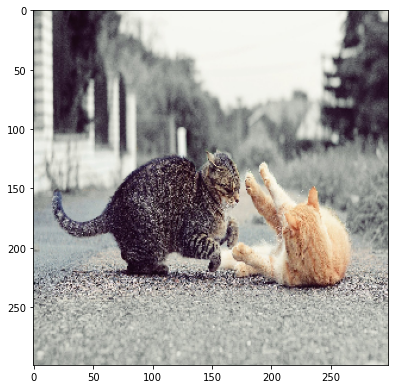

In [79]:
gen_caption('/kaggle/input/randomimg/cat.jpg', 14)